In [1]:
import json
import os
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import torch

from collections import defaultdict
from pprint import pprint
from typing import Dict, Tuple, List

from src.config.storage import ExperimentType
from src.storage import (
    get_dot_product_paraphrased_files, get_dot_product_model_generated_files,
    get_results_parameters_per_layer_folder_path, get_results_accuracy_per_layer_folder_path,
    get_results_layer_comparison_full_gradient_folder_path,
    get_results_self_similarities_over_layers_folder_path,
    get_gradient_similarity_paraphrased_random_projection_data,
    get_gradient_similarity_model_generated_random_projection_data,
    get_greedy_layer_selection_folder_path
)
from src.dataset import get_samples
from src.model import get_model, get_num_parameters_per_layer

In [2]:
def calculate_cosine_similarity(a_dot_b, a_dot_a, b_dot_b):
    # calculates the cosine similarity based on dot products
    return a_dot_b / (np.sqrt(a_dot_a) * np.sqrt(b_dot_b))

In [3]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [4]:
def calculate_score(gradient_similarities: dict):
    correct_counter = 0
    bm25_correct_counter = 0

    size = len(gradient_similarities.keys())

    for paraphrased_id, similarities in gradient_similarities.items():
        most_similar_original_id = max(similarities, key=similarities.get)
        correct_counter += int(paraphrased_id == most_similar_original_id)

        bm25_most_similar_original_id = list(similarities.keys())[0]
        bm25_correct_counter += int(paraphrased_id == bm25_most_similar_original_id)

    return correct_counter / size, bm25_correct_counter / size

In [5]:
def get_wrong_decisions(gradient_similarities: dict):
    wrong_decisions = []

    for original_id, similarities in gradient_similarities.items():
        most_similar_paraphrased_id = max(similarities, key=similarities.get)
        if original_id != most_similar_paraphrased_id:
            wrong_decisions.append(original_id)

    return wrong_decisions

In [6]:
def get_mean_similarity_of_most_similar_samples(gradient_similarities: dict, mean_function = np.mean):
    highest_similarities = []

    for original_id, similarities in gradient_similarities.items():
        highest_similarities.append(max(similarities.values()))

    return mean_function(highest_similarities)

In [7]:
def calculate_accuracy_per_layer(cosine_similarities_new_structure: dict):
    correct_counter_per_layer = defaultdict(int)

    # amount of paraphrased_samples
    size = len(next(iter(cosine_similarities_new_structure.values())).keys())

    for layer, values in cosine_similarities_new_structure.items():
        for paraphrased_id, original_ids in values.items():
            most_similar_original_id = max(original_ids, key=original_ids.get)
            correct_counter_per_layer[layer] += int(paraphrased_id == most_similar_original_id)

        # divide by size to get percentage
        correct_counter_per_layer[layer] /= size

    return correct_counter_per_layer

In [8]:
def get_cosine_similarities(dot_product_storage_function, model_to_evaluate: str, sample_size: int | None) -> \
    tuple[
        dict[str, dict[str, dict[str, float]]],
        dict[str, dict[str, dict[str, float]]],
        dict[str, dict[str, float]],
        dict[str, dict[str, dict[str, tuple[float, float, float]]]]
    ]:
    dot_products, paraphrased_dot_products, original_dot_products = dot_product_storage_function(model_to_evaluate, sample_size)

    # restructure such that layer is at outermost level in the dictionary for easier access afterward
    cosine_similarities_new_structure = dict()
    cosine_similarities_old_structure = dict()

    cosine_similarities_old_structure_combined = dict() # all gradients combined

    layer_dot_products = dict() # stores all the necessary intermediate dot products steps to calculate the cosine similarity for each layer

    for paraphrased_id, values in dot_products.items():
        cosine_similarities_old_structure[paraphrased_id] = dict()
        cosine_similarities_old_structure_combined[paraphrased_id] = dict()

        for original_id, layers in values.items():
            cosine_similarities_old_structure[paraphrased_id][original_id] = dict()
            cosine_similarities_old_structure_combined[paraphrased_id][original_id] = 0

            for layer, value in layers.items():
                if layer not in cosine_similarities_new_structure:
                    cosine_similarities_new_structure[layer] = dict()

                if paraphrased_id not in cosine_similarities_new_structure[layer]:
                    cosine_similarities_new_structure[layer][paraphrased_id] = dict()

                if layer not in layer_dot_products:
                    layer_dot_products[layer] = dict()

                if paraphrased_id not in layer_dot_products[layer]:
                    layer_dot_products[layer][paraphrased_id] = dict()

                similarity = calculate_cosine_similarity(value, paraphrased_dot_products[paraphrased_id][layer], original_dot_products[original_id][layer])

                cosine_similarities_old_structure[paraphrased_id][original_id][layer] = similarity
                cosine_similarities_new_structure[layer][paraphrased_id][original_id] = similarity

                layer_dot_products[layer][paraphrased_id][original_id] = (
                    value,
                    paraphrased_dot_products[paraphrased_id][layer],
                    original_dot_products[original_id][layer]
                )

                cosine_similarities_old_structure_combined[paraphrased_id][original_id] += value

            cosine_similarities_old_structure_combined[paraphrased_id][original_id] = calculate_cosine_similarity(
                cosine_similarities_old_structure_combined[paraphrased_id][original_id],
                sum(paraphrased_dot_products[paraphrased_id].values()),
                sum(original_dot_products[original_id].values())
            )

    # check if restructuring has worked by comparing iteratively with gradient_similarities dictionary
    for layer, values in cosine_similarities_new_structure.items():
        for paraphrased_id, original_ids in values.items():
            for original_id, similarity in original_ids.items():
                assert similarity == cosine_similarities_old_structure[paraphrased_id][original_id][layer]

    return cosine_similarities_new_structure, cosine_similarities_old_structure, cosine_similarities_old_structure_combined, layer_dot_products

In [9]:
def avg_by_component(accuracy_per_layer: dict, average_func = np.mean) -> dict:
    """
    Group by component name (embed_tokens, self_attn.q_proj, mlp.down_proj, ...),
    averaging across all layers.
    """
    buckets = defaultdict(list)
    for k, v in accuracy_per_layer.items():
        if k.startswith("model.embed_tokens"):
            comp = "embed_tokens"
        else:
            m = re.match(r"^model\.layers\.\d+\.(?P<comp>[^.]+\.[^.]+)\.", k)
            if not m:
                print(m)
                continue  # skip anything unexpected
            comp = m.group("comp")
        buckets[comp].append(v)
    return {comp: round(average_func(vals), ndigits=3) for comp, vals in buckets.items()}

In [10]:
def calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(
        gradient_similarities_per_layer_new_structure: dict[str, dict[str, dict[str, float]]],
        gradient_similarities_full_gradient_old_structure: dict[str, dict[str, float]],
) -> dict[str, float]:
    # compare each layer with the full gradient

    # flatten full gradient similarities for comparisons
    full_flattened = [item for values in gradient_similarities_full_gradient_old_structure.values() for item in values.values()]

    layer_similarity_compared_to_full_gradients = dict()

    for layer, similarities in gradient_similarities_per_layer_new_structure.items():
        layer_cosine_similarities_flattened = []

        for paraphrased_id, original_similarities in similarities.items():
            layer_cosine_similarities_flattened.extend(original_similarities.values())

        layer_similarity_compared_to_full_gradients[layer] = cosine_similarity(layer_cosine_similarities_flattened, full_flattened)

    return layer_similarity_compared_to_full_gradients

In [11]:
def get_random_projected_similarity_compared_to_full_gradient(
        gradient_similarity_random_projection_storage_function,
        model_to_evaluate: str,
        sample_size: int | None,
        gradient_similarities_full_gradient_old_structure: dict[str, dict[str, float]]
):
    full_flattened = [item for values in gradient_similarities_full_gradient_old_structure.values() for item in values.values()]

    random_projection_similarities_to_full_gradient = dict()

    for projection_dim, down_projected_values in gradient_similarity_random_projection_storage_function(model_to_evaluate, sample_size).items():
        projected_flattened = [item for values in down_projected_values.values() for item in values.values()]

        down_projected_similarity_compared_to_full_gradient = cosine_similarity(projected_flattened, full_flattened)

        random_projection_similarities_to_full_gradient[projection_dim] = down_projected_similarity_compared_to_full_gradient

    return random_projection_similarities_to_full_gradient

In [12]:
def greedy_forward_layer_selection(
    layer_dot_products: Dict[str, Dict[str, Dict[str, Tuple[float, float, float]]]],
    gradient_similarities_full_gradient_old_structure: Dict[str, Dict[str, float]],
) -> List[Tuple[str, float]]:
    """
    :param layer_dot_products:
    {
        "layer_component_1": {
            "paraphrased_id_1: {
                "original_id_a": (float, float, float), # (dot product between layer_component_1 gradient between samples paraphrased_id_1 and original_id_a, self dot product between layer_component_1 gradient of sample paraphrased_id_1 and paraphrased_id_1, self dot product between layer_component_1 gradient of sample original_id_a and original_id_a)
                "original_id_b": (float, float, float), # ...
            },
            "paraphrased_id_2": ...
        },
        layer_component_2: {
            "paraphrased_id_1": {
                "original_id_a": (float, float, float), ...
            ...
        },
        ...
    }
    :param gradient_similarities_full_gradient_old_structure: Has the structure
    {
        "praphrased_id_1": {
            "original_id_a: float, # cosine similarity between gradient paraphrased_id_1 and original_id_a
            "original_id_b: float, # cosine similarity between gradient paraphrased_id_2 and original_id_b
            "original_id_c: float, # cosine similarity between gradient paraphrased_id_3 and original_id_c
            "original_id_d: float, # cosine similarity between gradient paraphrased_id_4 and original_id_d
            "original_id_e: float # cosine similarity between gradient paraphrased_id_5 and original_id_e
        },
        "paraphrased_id_2": {
            "original_id_f: float, # cosine similarity between gradient paraphrased_id_5 and original_id_f
            "original_id_g: float, # cosine similarity between gradient paraphrased_id_6 and original_id_g
            "original_id_h: float, # cosine similarity between gradient paraphrased_id_7 and original_id_h
            "original_id_i: float, # cosine similarity between gradient paraphrased_id_8 and original_id_i
            "original_id_j: float # cosine similarity between gradient paraphrased_id_9 and original_id_j
        },
        ...
    }

    :return:
    """

    # -------------
    # 1) Flatten the (paraphrased_id, original_id) pairs in a fixed order (once)
    #    so we can vectorize all later computations.
    # -------------
    pairs: List[Tuple[str, str]] = []
    full_flattened_list: List[float] = []
    for paraphrased_id, originals in gradient_similarities_full_gradient_old_structure.items():
        for original_id, sim in originals.items():
            pairs.append((paraphrased_id, original_id))
            full_flattened_list.append(sim)

    full_flattened = np.asarray(full_flattened_list, dtype=np.float64)
    full_norm = np.linalg.norm(full_flattened) + 1e-12  # avoid division by zero
    P = len(pairs)

    # -------------
    # 2) Pre-build three NumPy arrays per layer: δ_ij, δ_ii, δ_jj
    #    This removes deep dict lookups and enables vectorized math.
    # -------------
    layer_names = list(layer_dot_products.keys())
    L = len(layer_names)

    # Using dicts of np.ndarray keeps the external interface intact
    delta_ij: Dict[str, np.ndarray] = {}
    delta_ii: Dict[str, np.ndarray] = {}
    delta_jj: Dict[str, np.ndarray] = {}

    for layer in layer_names:
        dp = np.zeros(P, dtype=np.float64)
        pp = np.zeros(P, dtype=np.float64)
        oo = np.zeros(P, dtype=np.float64)

        layer_map = layer_dot_products[layer]
        for idx, (paraphrased_id, original_id) in enumerate(pairs):
            try:
                dot_product, paraphrased_dot_product, original_dot_product = layer_map[paraphrased_id][original_id]
            except KeyError:
                # if the triple is missing for this pair, assume 0.0
                dot_product = paraphrased_dot_product = original_dot_product = 0.0
            dp[idx] = dot_product
            pp[idx] = paraphrased_dot_product
            oo[idx] = original_dot_product

        delta_ij[layer] = dp
        delta_ii[layer] = pp
        delta_jj[layer] = oo

    # -------------
    # 3) Greedy selection with *running accumulators* (no O(t) resumming)
    # -------------
    Dij = np.zeros(P, dtype=np.float64)
    Dii = np.zeros(P, dtype=np.float64)
    Djj = np.zeros(P, dtype=np.float64)

    remaining = set(layer_names)
    best_layers: List[Tuple[str, float]] = []

    eps = 1e-12

    for _ in range(L):
        best_rho = float("-inf")
        best_layer = None
        best_new_Dij = best_new_Dii = best_new_Djj = None

        # loop over remaining candidate layers
        for layer in remaining:
            new_Dij = Dij + delta_ij[layer]
            new_Dii = Dii + delta_ii[layer]
            new_Djj = Djj + delta_jj[layer]

            # cosine similarity reconstruction (vectorized)
            denom = np.sqrt(new_Dii) * np.sqrt(new_Djj)
            # where denom == 0, set c_hat to 0
            c_hat = np.divide(new_Dij, denom + eps, out=np.zeros_like(new_Dij), where=denom > 0)

            # cosine similarity between reconstructed similarities and full similarities
            c_norm = np.linalg.norm(c_hat) + eps

            rho = float(np.dot(c_hat, full_flattened) / (c_norm * full_norm))

            if rho > best_rho:
                best_rho = rho
                best_layer = layer
                best_new_Dij, best_new_Dii, best_new_Djj = new_Dij, new_Dii, new_Djj

        # Commit the winner of this round
        Dij, Dii, Djj = best_new_Dij, best_new_Dii, best_new_Djj
        remaining.remove(best_layer)
        best_layers.append((best_layer, best_rho))

    return best_layers

In [13]:
def find_top_k_examples_where_similarity_diverges_between_single_layer_gradient_and_full_gradient(
        layer_under_investigation: str,
        gradient_similarities_per_layer: dict[str, dict[str, dict[str, float]]],
        gradient_similarities_full_gradient: dict[str, dict[str, float]],
        k=3
) -> list[str]:
    # TODO: currently most divergent examples are used, however we want to have examples where the layer under investigation scores high and the full gradient scores worse
    layer_gradient_similarities = gradient_similarities_per_layer[layer_under_investigation]

    similarities = []

    for paraphrased_id, gradient_cosine_similarities in layer_gradient_similarities.items():
        if not gradient_cosine_similarities.keys() & gradient_similarities_full_gradient[paraphrased_id].keys():
            raise Exception(f"Paraphrased ID {paraphrased_id} does not have gradient similarities")

        similarities_sample = np.array(list(gradient_cosine_similarities.values()))
        similarities_full_gradient = np.array(list(gradient_similarities_full_gradient[paraphrased_id].values()))

        similarities.append(cosine_similarity(similarities_sample, similarities_full_gradient))

    most_divergent_example_indices = np.argsort(np.array(similarities))[:k]

    return list(np.array(list(layer_gradient_similarities.keys()))[most_divergent_example_indices])

In [14]:
def remove_strings_from_dataframe_column(column: pd.Series):
    return (column.astype(str)
            .str.replace(r"\bmodel.\b", "", case=False, regex=True)
            .str.replace(r"\b.weight\b", "", case=False, regex=True)
            .str.replace(r"\s+", " ", regex=True)   # collapse extra spaces
            .str.strip())

In [15]:
def horizontal_bar_plot(y, x, title, storage_folder_path, scale=None, ma_window=None):
    # Put data in a DataFrame so we control the order used for bars and MA
    df = pd.DataFrame({"y": y, "x": x})

    # remove model and weight from y values
    df["y"] = remove_strings_from_dataframe_column(df["y"])

    plt.figure(figsize=(8, max(4, 0.15 * len(df))))
    ax = sns.barplot(y=df["y"], x=df["x"], orient="h", order=df["y"].tolist())
    ax.set_title(title)

    if scale is not None:
        ax.set_xscale(scale)

    # Moving average (centered so it aligns nicely with bar centers)
    if ma_window is not None and ma_window > 1:
        x_ma = (
            df["x"]
            .astype(float)
            .rolling(window=ma_window, min_periods=1, center=True)
            .mean()
            .to_numpy()
        )
        # y positions are 0..n-1 for the horizontal bar centers
        y_pos = np.arange(len(df))
        ax.plot(x_ma, y_pos, linewidth=2, zorder=3, label=f"Moving avg (w={ma_window})")
        ax.legend(frameon=False)

    plt.margins(y=0.01)
    plt.tight_layout()
    plt.ylabel("")
    plt.xlabel("")
    plt.savefig(f"{storage_folder_path}/horizontal_bar_plot.png", bbox_inches="tight", dpi=600)
    plt.show()

In [16]:
def plot_gradient_similarities_over_layers(
        examples: list[str],
        gradient_similarities_per_layer_old_structure: dict[str, dict[str, dict[str, float]]],
        title: str,
        experiment_type: ExperimentType
):
    for paraphrased_example_under_investigation in examples:
        gradient_similarities_over_layers = pd.DataFrame(
            data=list(gradient_similarities_per_layer_old_structure["lima_0"]["lima_0"].keys()),
            columns=["layer"]
        )

        gradient_similarities_over_layers["layer"] = remove_strings_from_dataframe_column(gradient_similarities_over_layers["layer"])

        for original_example_to_compare in gradient_similarities_per_layer_old_structure[paraphrased_example_under_investigation]:
            gradient_similarities_over_layers[f"{paraphrased_example_under_investigation} <=> {original_example_to_compare}"] = list(gradient_similarities_per_layer_old_structure[paraphrased_example_under_investigation][original_example_to_compare].values())

        gradient_similarities_over_layers = gradient_similarities_over_layers.set_index("layer")

        plt.figure(figsize=(18, 8))
        sns.lineplot(data=gradient_similarities_over_layers)
        plt.ylabel("gradient similarity")
        plt.title(title)
        plt.xticks(rotation=90)

        plt.margins(y=0.01)

        storage_path = get_results_self_similarities_over_layers_folder_path(paraphrased_example_under_investigation, model_to_evaluate, experiment_type)

        plt.savefig(f"{storage_path}/line_plot.png", bbox_inches="tight", dpi=600)

        plt.show()

        gradient_similarities_over_layers.to_csv(os.path.join(storage_path, "gradient_similarities_over_layers.csv"))

In [17]:
def create_accumulated_plot_for_greedy_forward_layer_selection(
        greedily_selected_layers: list[tuple[str, float]],
        gradient_similarity_random_projection_data_storage_function,
        cosine_similarities_old_structure_combined: dict[str, dict[str, float]],
        model_to_evaluate: str,
        sample_size: int | None,
        experiment_type: ExperimentType
):
    # accumulate layer parameters for visualization
    parameter_percentage_accumulated_and_similarity_paraphrased = []
    accumulated_parameters = 0

    for layer, similarity_compared_to_full_gradient in greedily_selected_layers:
        accumulated_parameters += num_parameters_per_layer[layer]

        parameter_percentage_accumulated_and_similarity_paraphrased.append((accumulated_parameters / model.num_parameters() * 100, similarity_compared_to_full_gradient))

    down_projected_gradients_paraphrased_compared_to_full_gradient = get_random_projected_similarity_compared_to_full_gradient(
        gradient_similarity_random_projection_data_storage_function,
        model_to_evaluate,
        sample_size,
        cosine_similarities_old_structure_combined
    )

    sns.lineplot(data=pd.DataFrame(data=parameter_percentage_accumulated_and_similarity_paraphrased, columns=["percentage", 'similarity']), x="percentage", y="similarity", label="Greedy layer selection")

    colors = plt.get_cmap("Reds")(np.linspace(0.3, 1, len(down_projected_gradients_paraphrased_compared_to_full_gradient)))

    for (i, (projection_dim, similarity)) in enumerate(down_projected_gradients_paraphrased_compared_to_full_gradient.items()):
        percentage_of_full_parameters = int(projection_dim) / model.num_parameters() * 100
        plt.plot(
            percentage_of_full_parameters,
            similarity,
            "o",
            color=colors[i],
            label=f"{round(percentage_of_full_parameters)}% of params random projected"
        )

    plt.title(f"{model_to_evaluate} - {experiment_type.value} - greedy layer selection",)
    plt.legend()

    plt.savefig(f"{get_greedy_layer_selection_folder_path(model_to_evaluate, sample_size, experiment_type)}/plot.png", bbox_inches="tight", dpi=600)

    plt.show()

In [18]:
model_to_evaluate = "amd/AMD-OLMo-1B-SFT"
#model_to_evaluate = "allenai/OLMo-7B-SFT-hf"
#sample_size = 100
sample_size = None

#model_to_evaluate = "openai-community/gpt2"
#sample_size = 2

In [19]:
model = get_model(model_to_evaluate, device=torch.device('cpu')) # load model on cpu since no more computations are needed

Device: cpu
Model parameters: 1176764416
OlmoForCausalLM(
  (model): OlmoModel(
    (embed_tokens): Embedding(50304, 2048, padding_idx=1)
    (layers): ModuleList(
      (0-15): 16 x OlmoDecoderLayer(
        (self_attn): OlmoAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): OlmoMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): OlmoLayerNorm()
        (post_attention_layernorm): OlmoLayerNorm()
      )
    )
    (norm): OlmoLayerNorm()
    (rotary_emb)

In [20]:
num_parameters_per_layer = get_num_parameters_per_layer(model)

assert sum(num_parameters_per_layer.values()) == model.num_parameters()

pprint(num_parameters_per_layer, indent=4, sort_dicts=False)

{   'model.embed_tokens.weight': 103022592,
    'model.layers.0.self_attn.q_proj.weight': 4194304,
    'model.layers.0.self_attn.k_proj.weight': 4194304,
    'model.layers.0.self_attn.v_proj.weight': 4194304,
    'model.layers.0.self_attn.o_proj.weight': 4194304,
    'model.layers.0.mlp.gate_proj.weight': 16777216,
    'model.layers.0.mlp.up_proj.weight': 16777216,
    'model.layers.0.mlp.down_proj.weight': 16777216,
    'model.layers.1.self_attn.q_proj.weight': 4194304,
    'model.layers.1.self_attn.k_proj.weight': 4194304,
    'model.layers.1.self_attn.v_proj.weight': 4194304,
    'model.layers.1.self_attn.o_proj.weight': 4194304,
    'model.layers.1.mlp.gate_proj.weight': 16777216,
    'model.layers.1.mlp.up_proj.weight': 16777216,
    'model.layers.1.mlp.down_proj.weight': 16777216,
    'model.layers.2.self_attn.q_proj.weight': 4194304,
    'model.layers.2.self_attn.k_proj.weight': 4194304,
    'model.layers.2.self_attn.v_proj.weight': 4194304,
    'model.layers.2.self_attn.o_proj.

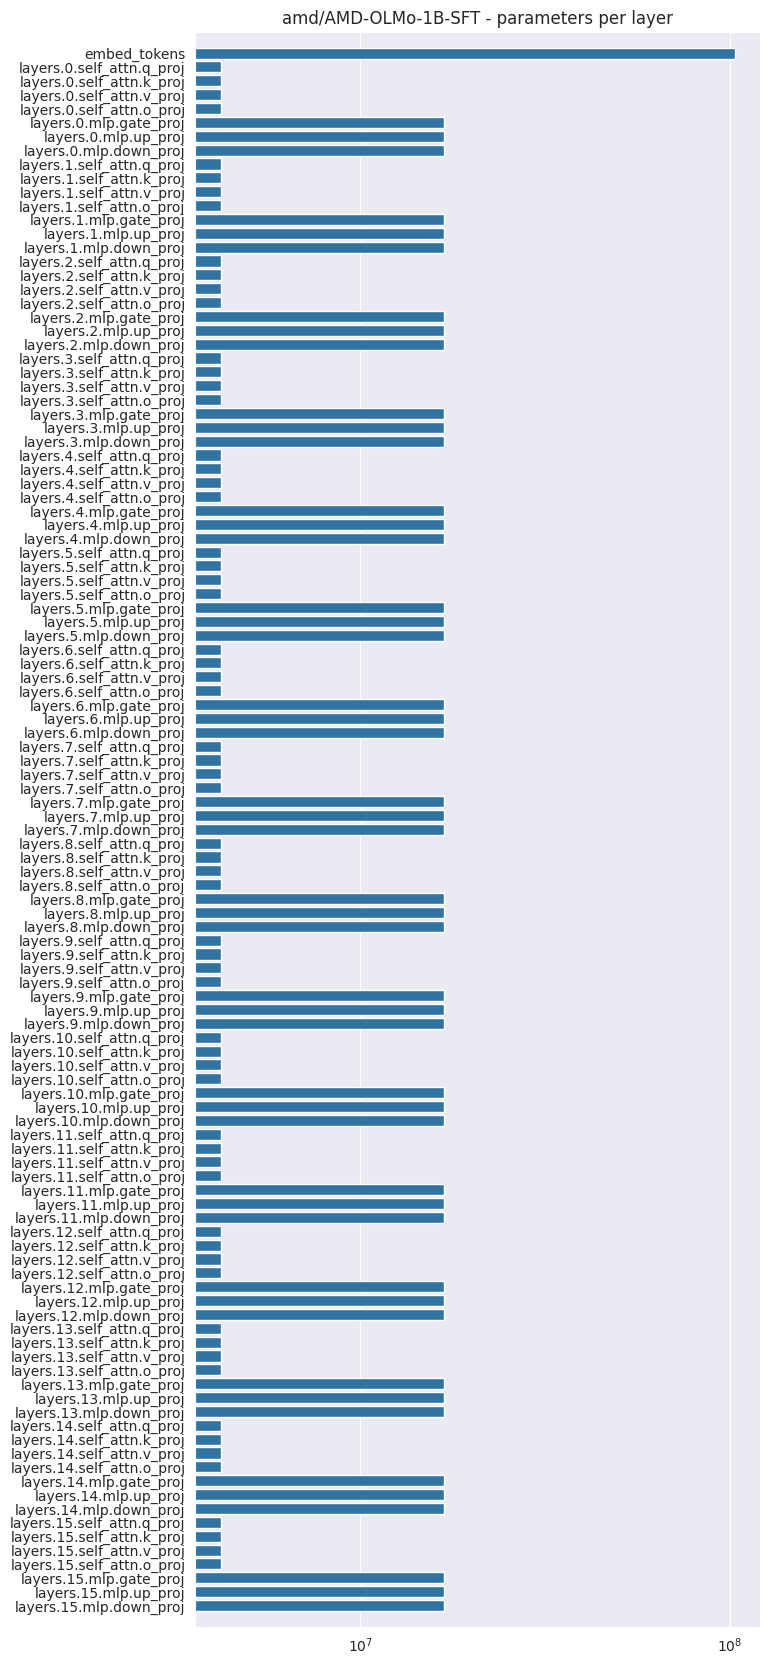

In [21]:
horizontal_bar_plot(
    y=list(num_parameters_per_layer.keys()),
    x=list(num_parameters_per_layer.values()),
    title=f"{model_to_evaluate} - parameters per layer",
    storage_folder_path=f"{get_results_parameters_per_layer_folder_path(model_to_evaluate)}",
    scale='log',
)

with open(f"{get_results_parameters_per_layer_folder_path(model_to_evaluate)}/values.json", "w") as f:
    json.dump(num_parameters_per_layer, f, indent=4)

In [22]:
cosine_similarities_new_structure_paraphrased, cosine_similarities_old_structure_paraphrased, cosine_similarities_old_structure_combined_paraphrased, layer_dot_products_paraphrased = get_cosine_similarities(get_dot_product_paraphrased_files, model_to_evaluate, sample_size)

# 1. BM25 Selected Paraphrased

In [23]:
model_score, bm25_score = calculate_score(cosine_similarities_old_structure_combined_paraphrased)
wrong_decisions = get_wrong_decisions(cosine_similarities_old_structure_combined_paraphrased)
mean_similarity = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_paraphrased)
mean_similarity_score_median = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_paraphrased, np.median)

print(f"Model score: {model_score}")
print(f"BM25 score: {bm25_score}")
print(f"Mean similarity (average): {mean_similarity}")
print(f"Mean similarity (median): {mean_similarity_score_median}")

Model score: 0.992914979757085
BM25 score: 0.8360323886639676
Mean similarity (average): 0.4453259535564719
Mean similarity (median): 0.43923551600197697


## 1.1 Layer Analysis

In [24]:
accuracy_per_layer_paraphrased = calculate_accuracy_per_layer(cosine_similarities_new_structure_paraphrased)

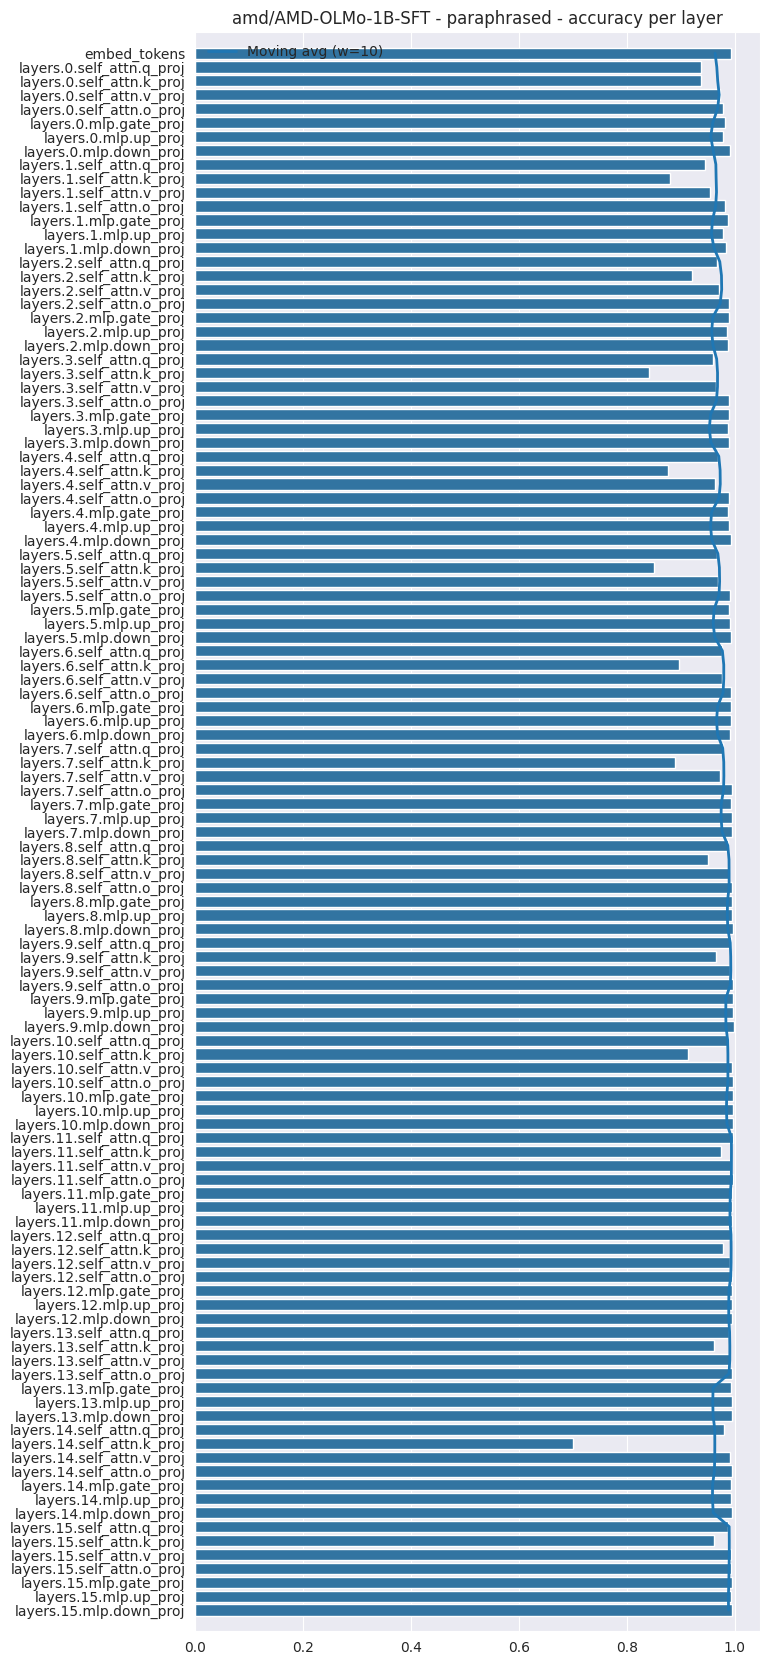

In [25]:
horizontal_bar_plot(
    y=list(accuracy_per_layer_paraphrased.keys()),
    x=list(accuracy_per_layer_paraphrased.values()),
    title=f"{model_to_evaluate} - paraphrased - accuracy per layer",
    storage_folder_path=get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED),
    ma_window=10
)

with open(f"{get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED)}/values.json", "w") as f:
    json.dump(accuracy_per_layer_paraphrased, f, indent=4)

In [26]:
avg_by_component(accuracy_per_layer_paraphrased, np.median)

{'embed_tokens': 0.993,
 'self_attn.q_proj': 0.979,
 'self_attn.k_proj': 0.916,
 'self_attn.v_proj': 0.982,
 'self_attn.o_proj': 0.994,
 'mlp.gate_proj': 0.994,
 'mlp.up_proj': 0.993,
 'mlp.down_proj': 0.995}

### 1.1.1 Example Similarities over Layers

In [27]:
layer_with_best_score_paraphrased = max(accuracy_per_layer_paraphrased, key=accuracy_per_layer_paraphrased.get)
layer_with_best_score_paraphrased

'model.layers.9.mlp.down_proj.weight'

In [28]:
examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_paraphrased = find_top_k_examples_where_similarity_diverges_between_single_layer_gradient_and_full_gradient(layer_with_best_score_paraphrased, cosine_similarities_new_structure_paraphrased, cosine_similarities_old_structure_combined_paraphrased)

In [29]:
examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_paraphrased

['lima_802', 'lima_815', 'lima_849']

In [30]:
for sample in get_samples(examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_paraphrased):
    original_user_message = sample["messages"][0]["content"].replace("\n", "\n\t\t")
    original_assistant_message = sample["messages"][1]["content"].replace("\n", "\n\t\t")

    paraphrased_user_message = sample['paraphrased_messages'][0]['content'].replace("\n", "\n\t\t")
    paraphrased_assistant_message = sample['paraphrased_messages'][1]['content'].replace("\n", "\n\t\t")


    print(f"============{sample['id']}============")
    print("original:")
    print("\tuser message:")
    print(f"\t\t{original_user_message}")
    print()
    print("\tassistant message:")
    print(f"\t\t{original_assistant_message}")

    print("-----")

    print("paraphrased:")
    print("\tuser message:")
    print(f"\t\t{paraphrased_user_message}")
    print()
    print("\tassistant message:")
    print(f"\t\t{paraphrased_assistant_message}")

============lima_802============
original:
	user message:
		Translate the following text into English.
		
		人们应该尊重不同的文化和信仰，互相理解和包容。

	assistant message:
		People should respect different cultures and beliefs and understand and tolerate each other.
-----
paraphrased:
	user message:
		People should respect different cultures and beliefs, and understand and tolerate each other.

	assistant message:
		Individuals ought to honor various cultures and beliefs while seeking to comprehend and accept one another.
============lima_815============
original:
	user message:
		Rewrite the sentence in order to make it easier to understand by non-native speakers of English. You can do so by replacing complex words with simpler synonyms (i.e. paraphrasing), deleting unimportant information (i.e. compression), and/or splitting a long complex sentence into several simpler ones. The final simplified sentences need to be grammatical, fluent, and retain the main ideas of their original counterparts without a

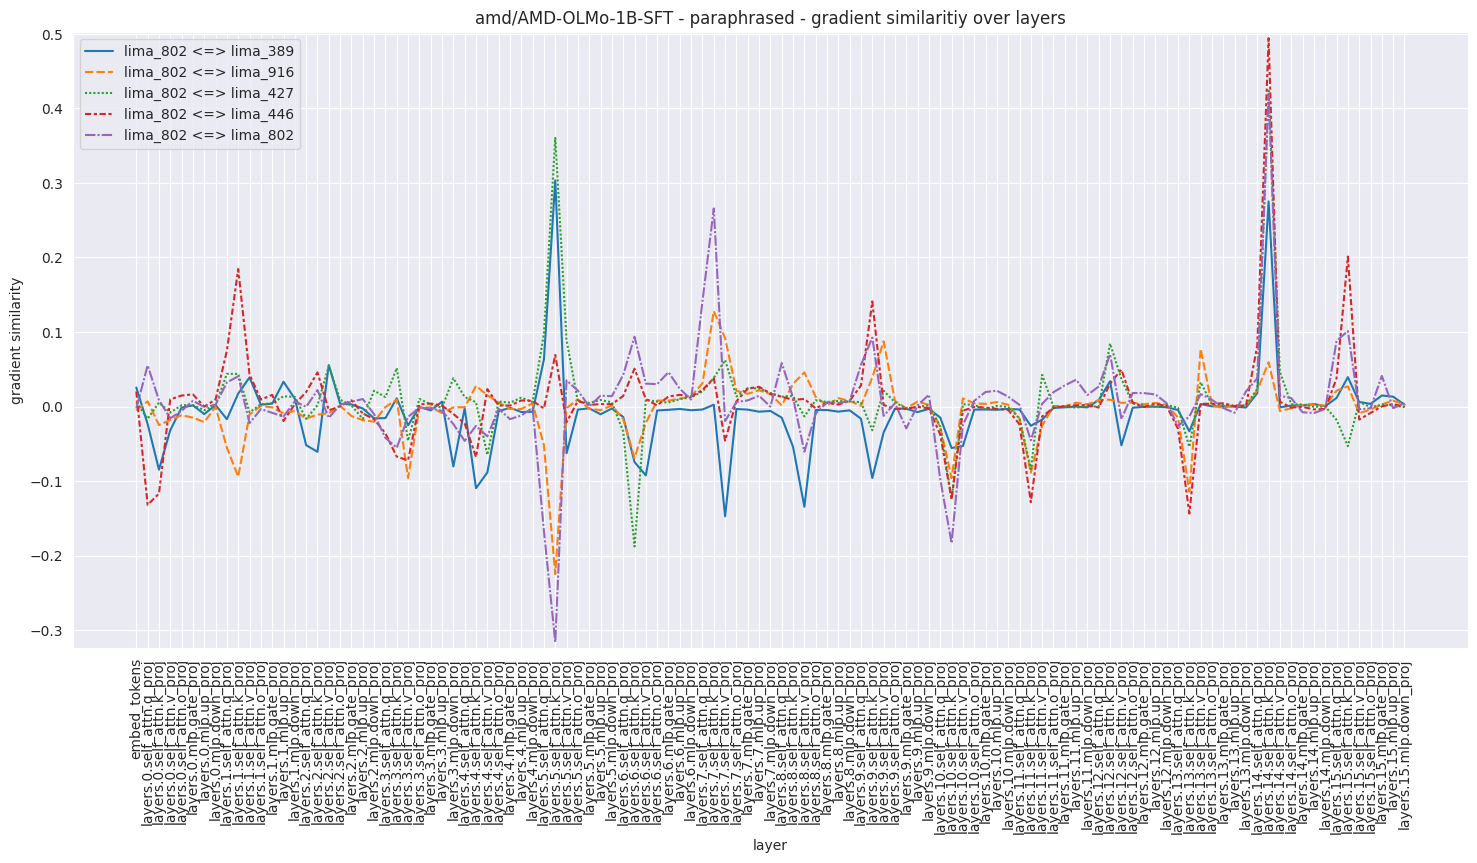

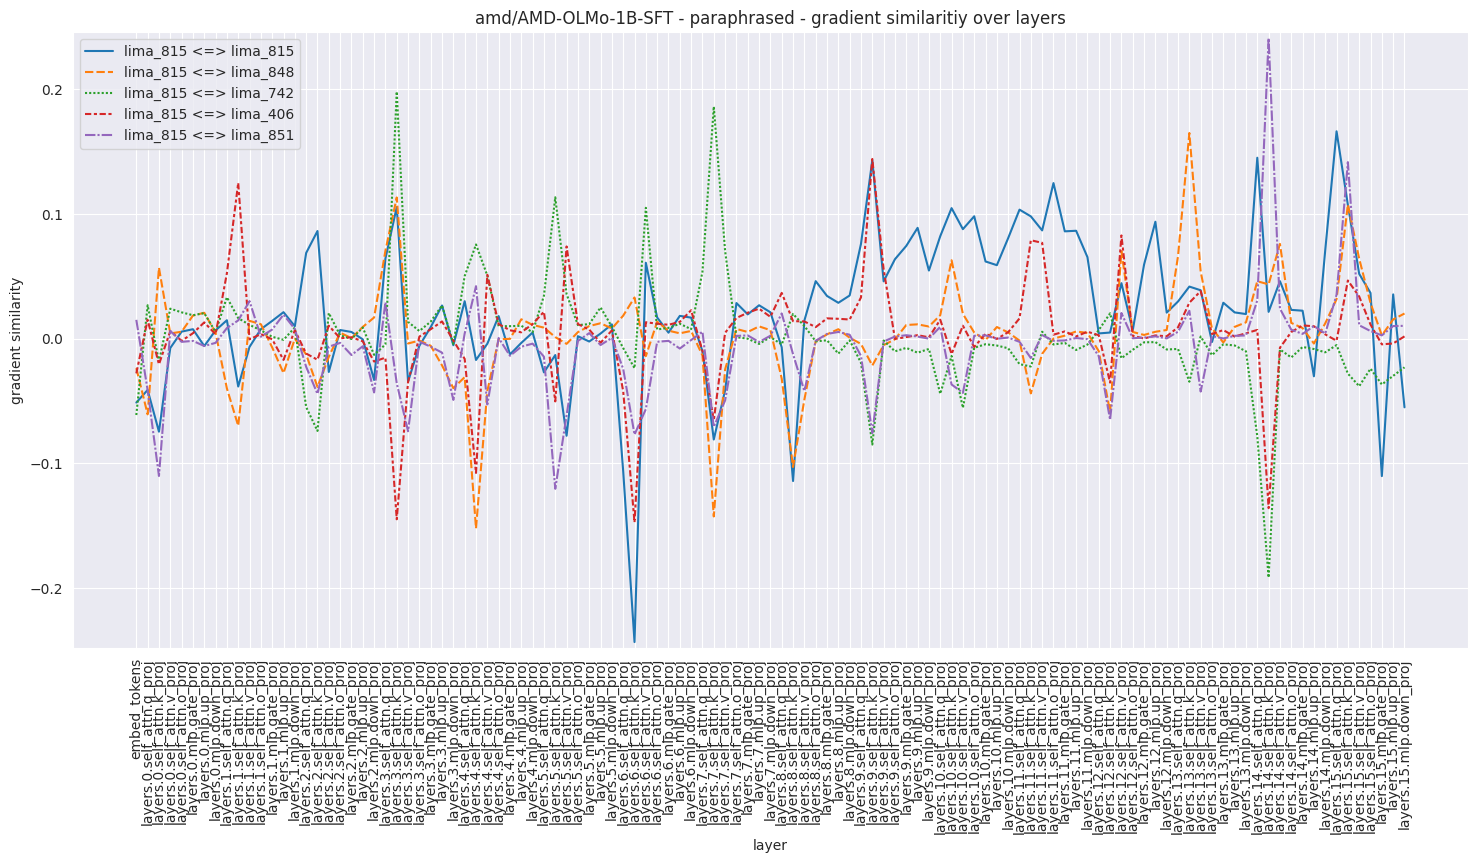

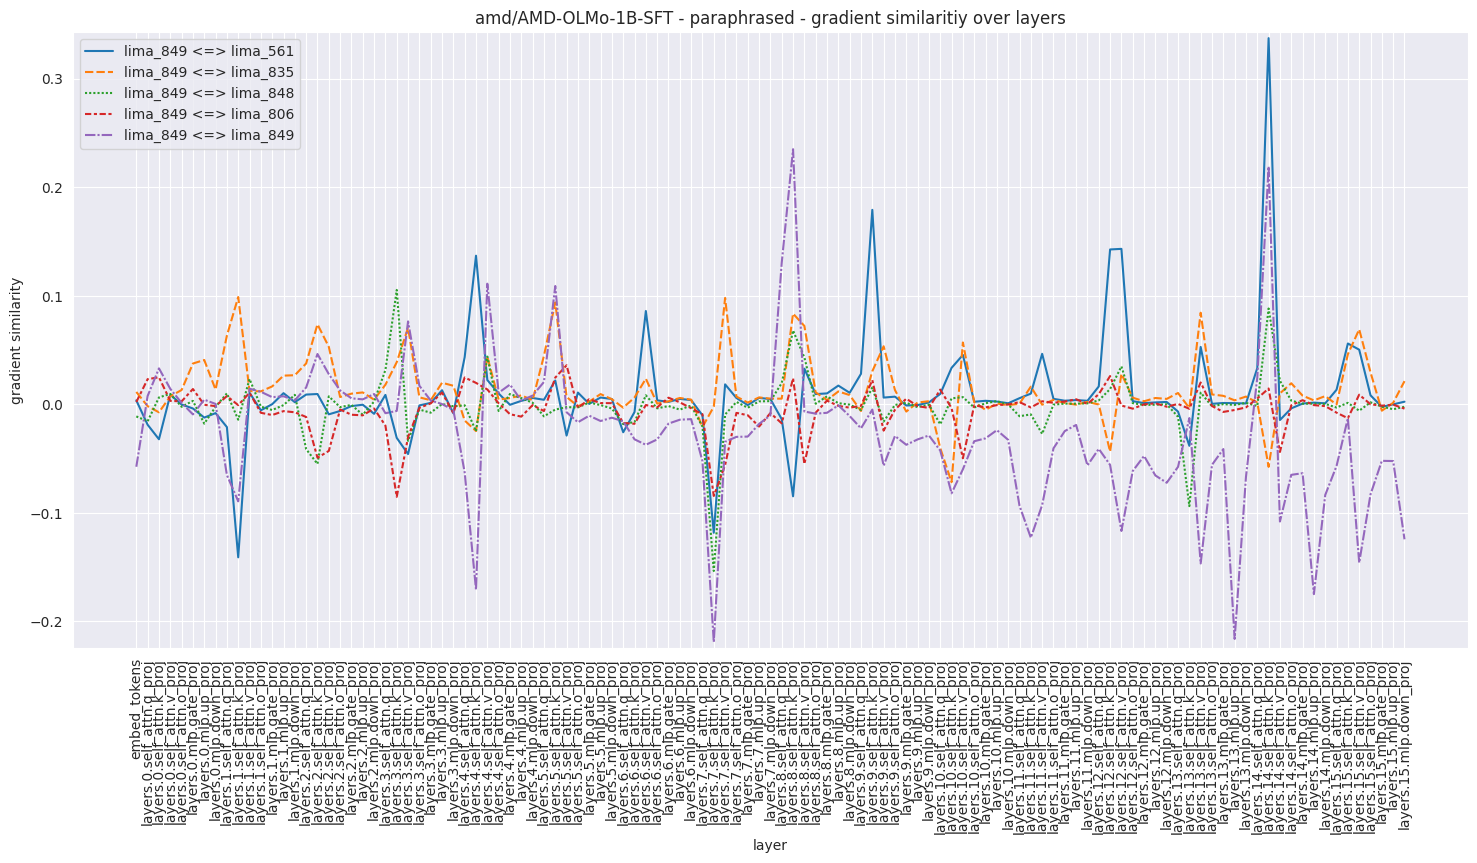

In [31]:
plot_gradient_similarities_over_layers(
    examples=examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_paraphrased,
    gradient_similarities_per_layer_old_structure=cosine_similarities_old_structure_paraphrased,
    title=f"{model_to_evaluate} - paraphrased - gradient similaritiy over layers",
    experiment_type=ExperimentType.PARAPHRASED
)

## 1.2 Comparison between Layer-Gradient-Similarities and Full-Gradient-Similarities

In [32]:
layer_similarity_compared_to_full_gradients_paraphrased = calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(cosine_similarities_new_structure_paraphrased, cosine_similarities_old_structure_combined_paraphrased)

In [33]:
max(layer_similarity_compared_to_full_gradients_paraphrased, key=layer_similarity_compared_to_full_gradients_paraphrased.get)

'model.layers.6.mlp.up_proj.weight'

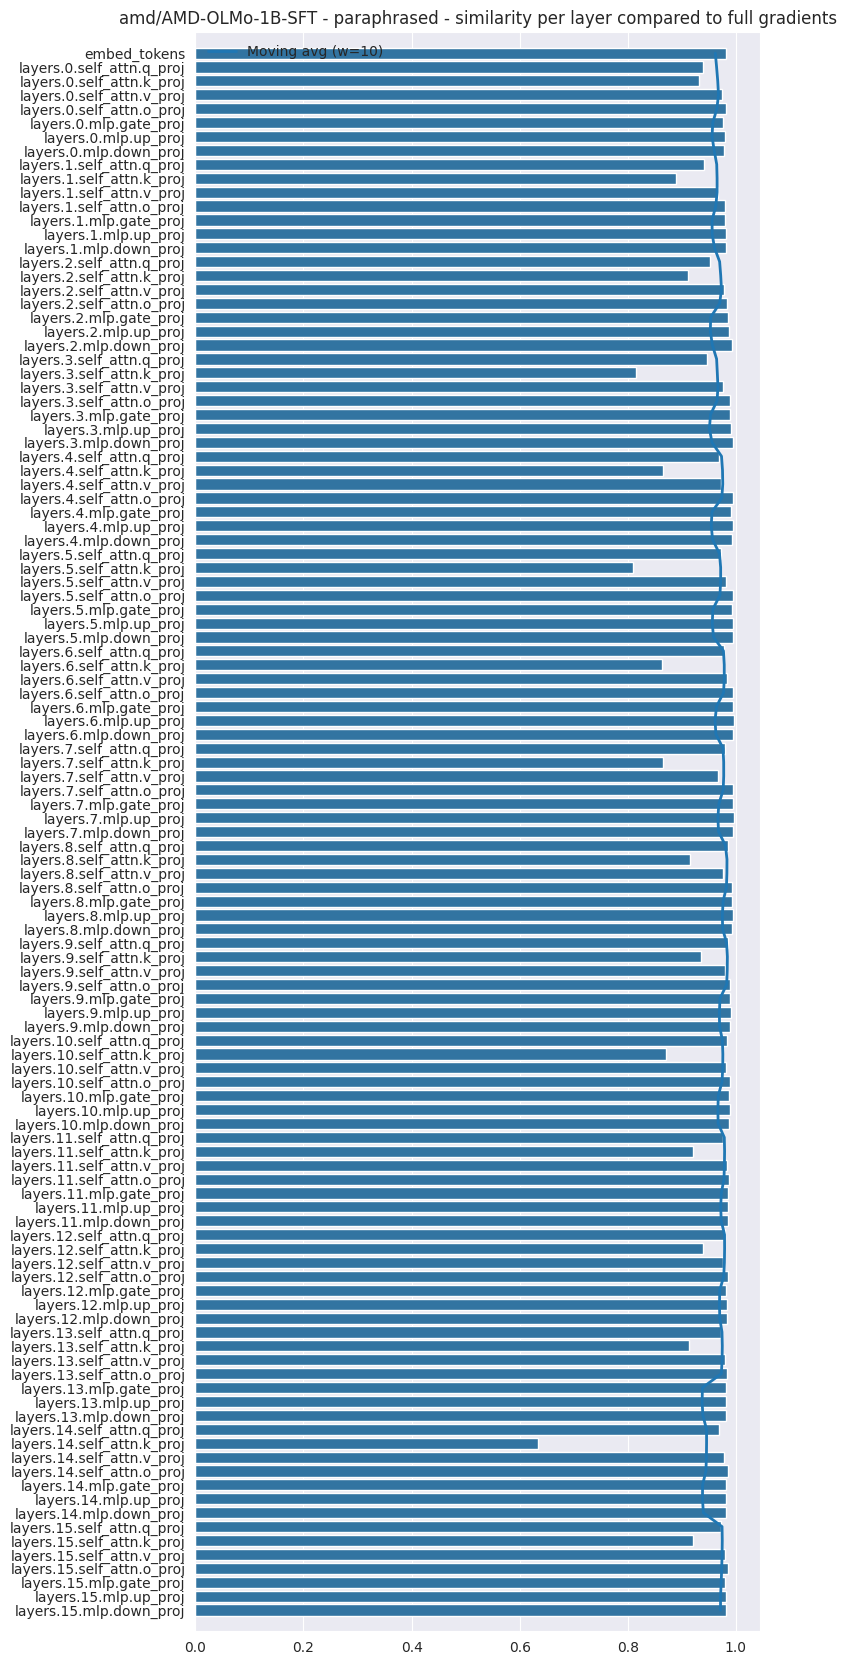

In [34]:
horizontal_bar_plot(
    y=list(layer_similarity_compared_to_full_gradients_paraphrased.keys()),
    x=list(layer_similarity_compared_to_full_gradients_paraphrased.values()),
    title=f"{model_to_evaluate} - paraphrased - similarity per layer compared to full gradients",
    storage_folder_path=get_results_layer_comparison_full_gradient_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED),
    ma_window=10
)

with open(f"{get_results_layer_comparison_full_gradient_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED)}/values.json", "w") as f:
    json.dump(layer_similarity_compared_to_full_gradients_paraphrased, f, indent=4)

In [35]:
avg_by_component(layer_similarity_compared_to_full_gradients_paraphrased, np.median)

{'embed_tokens': 0.981,
 'self_attn.q_proj': 0.972,
 'self_attn.k_proj': 0.9,
 'self_attn.v_proj': 0.978,
 'self_attn.o_proj': 0.988,
 'mlp.gate_proj': 0.986,
 'mlp.up_proj': 0.988,
 'mlp.down_proj': 0.989}

### 1.2.1 Greedy Layer Selection based on Full-Gradient-Comparison

In [36]:
greedily_selected_layers_paraphrased = greedy_forward_layer_selection(layer_dot_products_paraphrased, cosine_similarities_old_structure_combined_paraphrased)

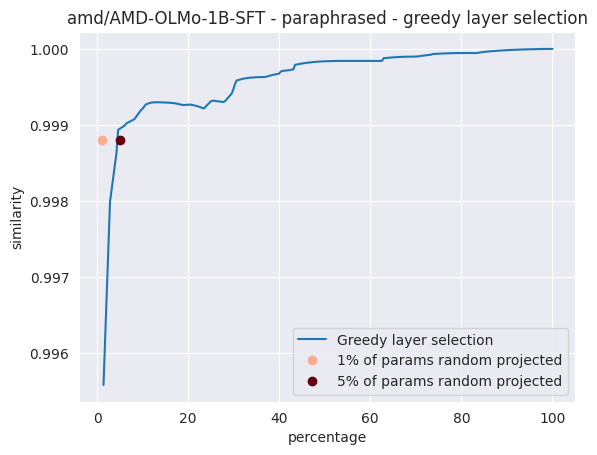

In [37]:
create_accumulated_plot_for_greedy_forward_layer_selection(
    greedily_selected_layers_paraphrased,
    get_gradient_similarity_paraphrased_random_projection_data,
    cosine_similarities_old_structure_combined_paraphrased,
    model_to_evaluate,
    sample_size,
    ExperimentType.PARAPHRASED
)

# 2. BM25 Selected Model Generated

In [38]:
cosine_similarities_new_structure_model_generated, cosine_similarities_old_structure_model_generated, cosine_similarities_old_structure_combined_model_generated, layer_dot_products_model_generated = get_cosine_similarities(get_dot_product_model_generated_files, model_to_evaluate, sample_size)

In [39]:
model_score_model_generated, bm25_score_model_generated = calculate_score(cosine_similarities_old_structure_combined_model_generated)
wrong_decisions_model_generated = get_wrong_decisions(cosine_similarities_old_structure_combined_model_generated)
mean_similarity_model_generated = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_model_generated)
mean_similarity_score_median_model_generated = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_model_generated, np.median)

print(f"Model score: {model_score_model_generated}")
print(f"BM25 score: {bm25_score_model_generated}")
print(f"Mean similarity (average): {mean_similarity_model_generated}")
print(f"Mean similarity (median): {mean_similarity_score_median_model_generated}")

Model score: 0.21761133603238866
BM25 score: 0.8360323886639676
Mean similarity (average): 0.018380379908200538
Mean similarity (median): 0.012993619464051021


## 2.1 Layer Analysis

In [40]:
accuracy_per_layer_model_generated = calculate_accuracy_per_layer(cosine_similarities_new_structure_model_generated)

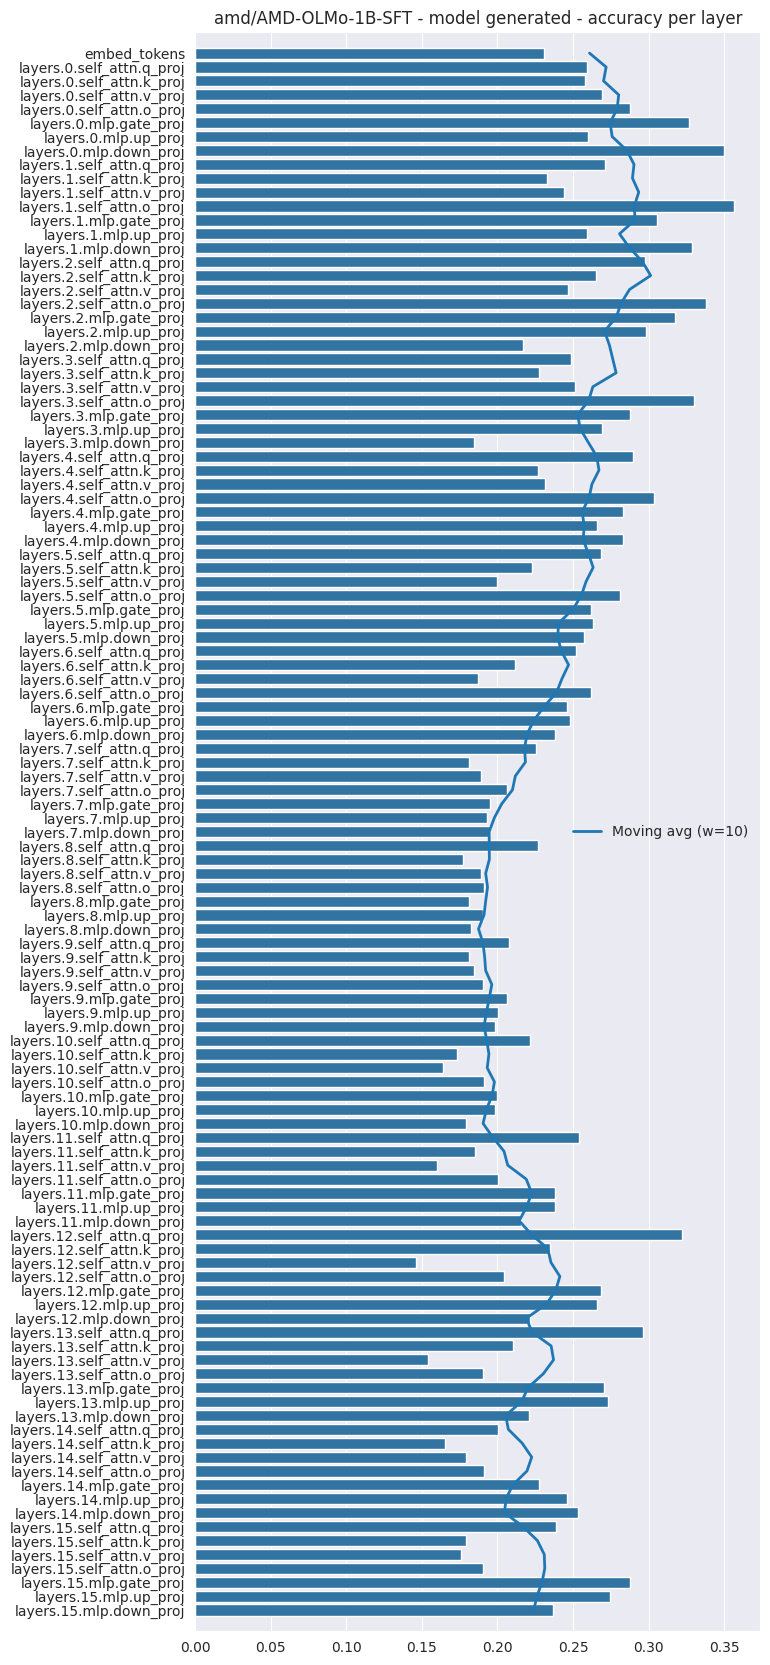

In [41]:
horizontal_bar_plot(
    y=list(accuracy_per_layer_model_generated.keys()),
    x=list(accuracy_per_layer_model_generated.values()),
    title=f"{model_to_evaluate} - model generated - accuracy per layer",
    storage_folder_path=get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED),
    ma_window=10
)

with open(f"{get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED)}/values.json", "w") as f:
    json.dump(accuracy_per_layer_model_generated, f, indent=4)

In [42]:
avg_by_component(accuracy_per_layer_model_generated, np.median)

{'embed_tokens': 0.231,
 'self_attn.q_proj': 0.253,
 'self_attn.k_proj': 0.211,
 'self_attn.v_proj': 0.188,
 'self_attn.o_proj': 0.205,
 'mlp.gate_proj': 0.265,
 'mlp.up_proj': 0.26,
 'mlp.down_proj': 0.221}

### 2.1.1 Example Similarities over Layers

In [43]:
layer_with_best_score_model_generated = max(accuracy_per_layer_model_generated, key=accuracy_per_layer_model_generated.get)
layer_with_best_score_model_generated

'model.layers.1.self_attn.o_proj.weight'

In [44]:
examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_model_generated = find_top_k_examples_where_similarity_diverges_between_single_layer_gradient_and_full_gradient(
    layer_with_best_score_model_generated,
    cosine_similarities_new_structure_model_generated,
    cosine_similarities_old_structure_combined_model_generated
)

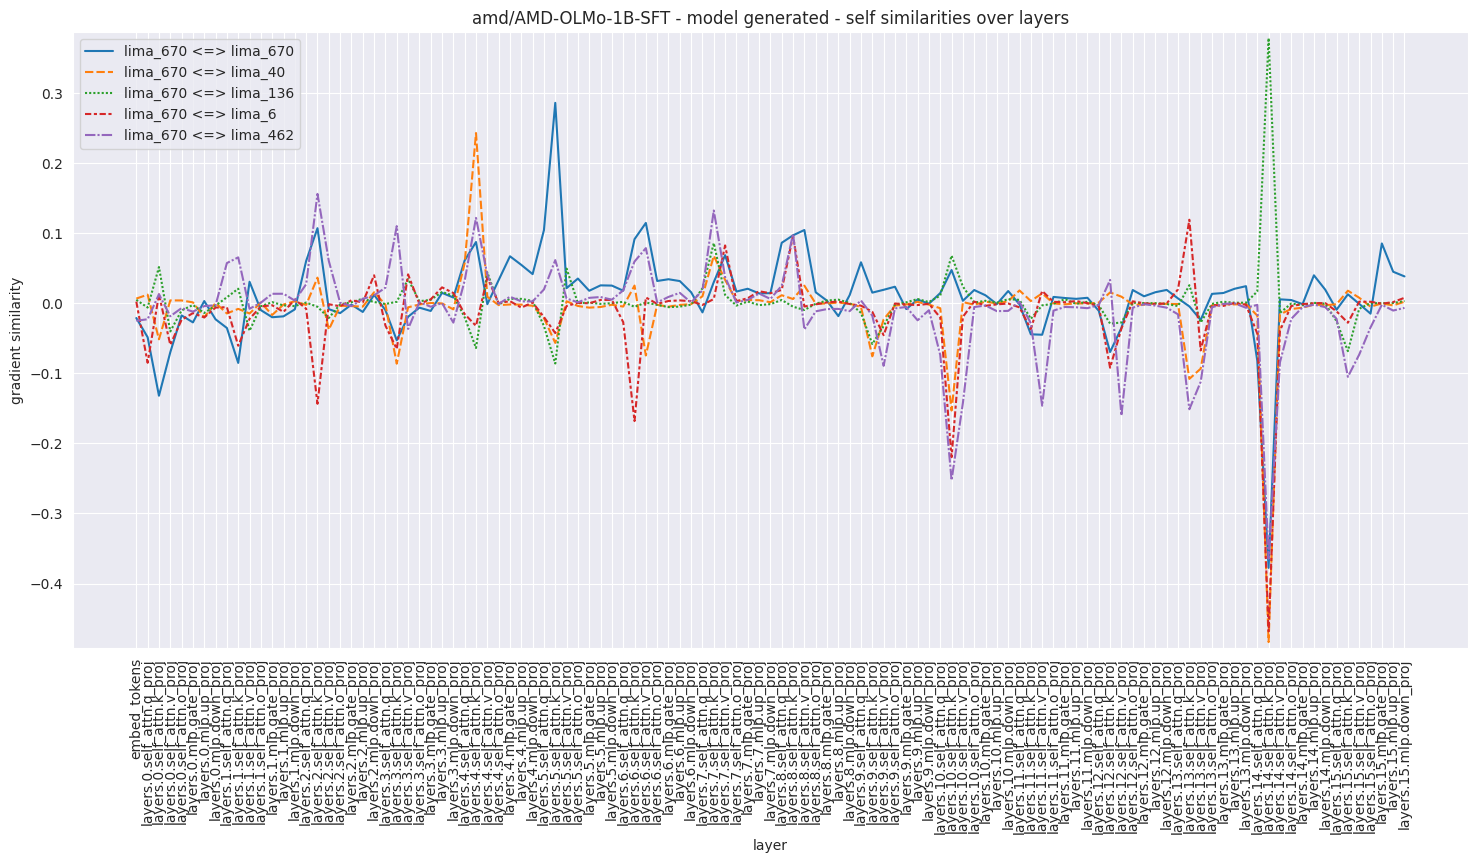

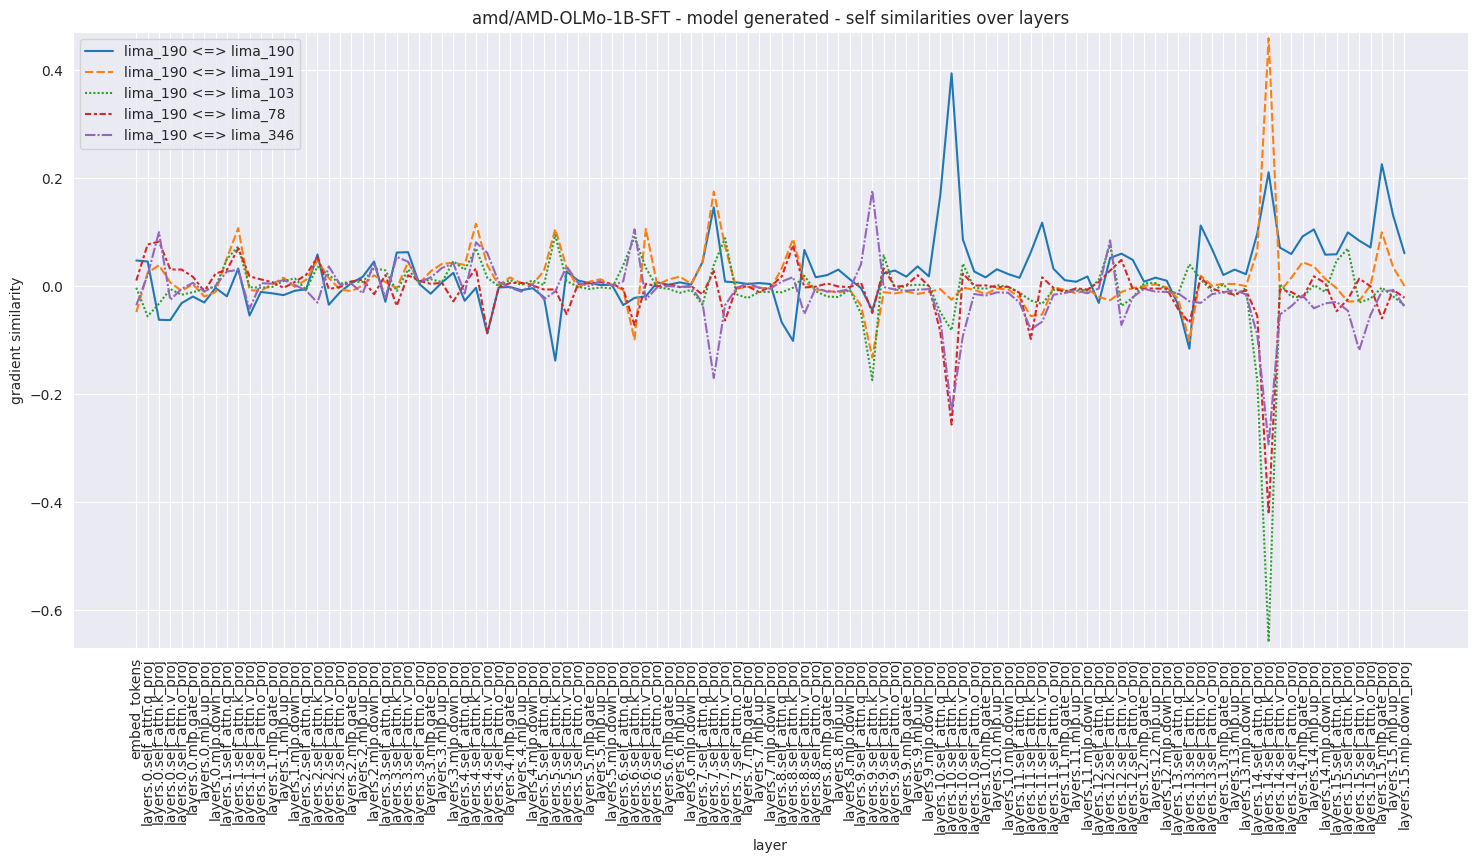

In [45]:
plot_gradient_similarities_over_layers(
    examples=examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_model_generated,
    gradient_similarities_per_layer_old_structure=cosine_similarities_old_structure_model_generated,
    title=f"{model_to_evaluate} - model generated - self similarities over layers",
    experiment_type=ExperimentType.MODEL_GENERATED
)

## 2.2 Comparison between Layer-Gradient-Similarities and Full-Gradient-Similarities

In [46]:
layer_similarity_compared_to_full_gradients_model_generated = calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(cosine_similarities_new_structure_model_generated, cosine_similarities_old_structure_combined_model_generated)

In [47]:
max(layer_similarity_compared_to_full_gradients_model_generated, key=layer_similarity_compared_to_full_gradients_model_generated.get)

'model.layers.3.mlp.down_proj.weight'

In [48]:
horizontal_bar_plot(
    y=list(layer_similarity_compared_to_full_gradients_model_generated.keys()),
    x=list(layer_similarity_compared_to_full_gradients_model_generated.values()),
    title=f"{model_to_evaluate} - model generated - similarity per layer compared to full gradients",
    storage_folder_path=get_results_layer_comparison_full_gradient_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED),
    ma_window=10
)

with open(f"{get_results_layer_comparison_full_gradient_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED)}/values.json", "w") as f:
    json.dump(layer_similarity_compared_to_full_gradients_model_generated, f, indent=4)

In [49]:
avg_by_component(layer_similarity_compared_to_full_gradients_model_generated, np.median)

{'embed_tokens': 0.275,
 'self_attn.q_proj': 0.275,
 'self_attn.k_proj': 0.201,
 'self_attn.v_proj': 0.62,
 'self_attn.o_proj': 0.63,
 'mlp.gate_proj': 0.553,
 'mlp.up_proj': 0.571,
 'mlp.down_proj': 0.63}

### 2.2.1 Greedy Layer Selection based on Full-Gradient-Comparison

In [50]:
greedily_selected_layers_model_generated = greedy_forward_layer_selection(layer_dot_products_model_generated, cosine_similarities_old_structure_combined_model_generated)

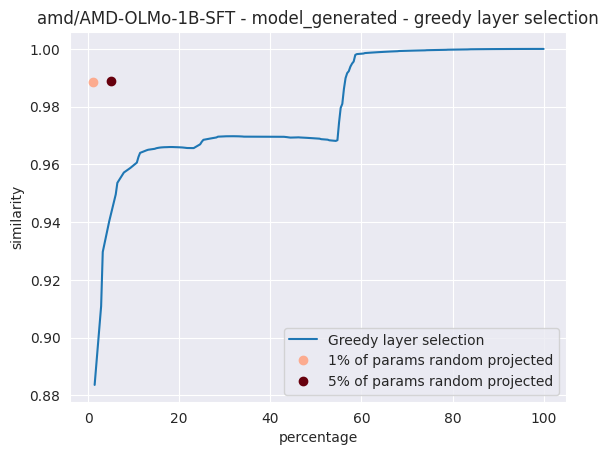

In [51]:
create_accumulated_plot_for_greedy_forward_layer_selection(
    greedily_selected_layers_model_generated,
    get_gradient_similarity_model_generated_random_projection_data,
    cosine_similarities_old_structure_combined_model_generated,
    model_to_evaluate,
    sample_size,
    ExperimentType.MODEL_GENERATED
)

# 3. Accuracy Comparison

In [52]:
# create bar plot with paraphrased_score, paraphrased_model_generated_score, and horizontal line at 0.2 baseline
sns.barplot(x=["para_para <-> orig_orig", "para_gen <-> orig_orig"], y=[model_score, model_score_model_generated])

plt.axhline(y=0.2, color='r', linestyle='--', label="random guessing")
plt.legend()
plt.show()